# Text summarization of Hotel Reviews using Huggingface Transoformers T5 and Bart

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration, BartConfig

model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

summarized_text = []

review = "Psychologist B. F. Skinner saw that classical conditioning is limited to existing behaviors that are reflexively elicited, \
and it doesn’t account for new behaviors such as riding a bike. He proposed a theory about how such behaviors come about. \
Skinner believed that behavior is motivated by the consequences we receive for the behavior: the reinforcements and punishments. \
His idea that learning is the result of consequences is based on the law of effect, which was first proposed by psychologist Edward Thorndike. \
According to the law of effect, behaviors that are followed by consequences that are satisfying to the organism are more likely to be repeated, \
and behaviors that are followed by unpleasant consequences are less likely to be repeated (Thorndike, 1911). Essentially, if an organism does \
something that brings about a desired result, the organism is more likely to do it again. If an organism does something that does not bring about a desired result, \
the organism is less likely to do it again. An example of the law of effect is in employment. One of the reasons (and often the main reason) we show up for work is \
because we get paid to do so. If we stop getting paid, we will likely stop showing up—even if we love our job. Working with Thorndike’s law of effect as his foundation, \
Skinner began conducting scientific experiments on animals (mainly rats and pigeons) to determine how organisms learn through operant conditioning (Skinner, 1938). \
He placed these animals inside an operant conditioning chamber, which has come to be known as a “Skinner box” (Figure 1). A Skinner box contains a lever (for rats) or disk (for pigeons) that the animal can press or peck for a food reward via the dispenser. Speakers and lights can be associated with certain behaviors. A recorder counts the number of responses made by the animal."
 
preprocess_text = review.strip().replace("\n","")
bart_inputText = "summarize: "+preprocess_text

tokenized_text = tokenizer([review], truncation=True, return_tensors='pt')

summary_ids = model.generate(tokenized_text['input_ids'], num_beams=4,
                               min_length=30, max_length=300, early_stopping=True)
for si in summary_ids:
    summarized_text.append(tokenizer.decode(si, skip_special_tokens=True,
                                            clean_up_tokenization_spaces=False))

In [ ]:
summarized_text

['Psychologist B. F. Skinner saw that classical conditioning is limited to existing behaviors that are reflexively elicited. He proposed a theory about how such behaviors come about. Skinner believed that behavior is motivated by the consequences we receive.']

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!pip install transformers

     |████████████████████████████████| 1.5MB 23.6MB/s 
     |████████████████████████████████| 2.9MB 46.2MB/s 
     |████████████████████████████████| 890kB 53.1MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=2b6e8b018900b513800b254eb1795e8096df41d4bd5cfd75d7e2dbc6550ba725
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import pandas as pd
import re
from nltk.stem import PorterStemmer
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB
from sklearn.metrics import precision_recall_curve
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration, T5Config

I have kept my review files (1141) files in google drive for pre-processing on given location.

In [ ]:
filePath = r'/content/gdrive/My Drive/review/'

*   Review files contains data in comma seperated format, where date, review_title and review_text present respectively in each file
*   Only keeping review_text with length of > 100
*   Total reviews as shown below are 76634



In [ ]:
df = pd.read_csv(filePath + 'summary.csv')
df = df.dropna(subset = ['rating'])
df = df.dropna(subset = ['sentiment'])
df.head()

,number,website,hotel,review,rating,sentiment
0,112386669,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,The suite was exceptional...spacious and comfo...,5.0,positive
1,99145909,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"This is what hotels should be like. Clean, lar...",4.0,positive
2,97597588,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"The room was beautiful and spacious, but the f...",3.0,negative
3,96239840,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,I have been staying here off and on most weeks...,5.0,positive
4,96025643,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"Dear M, I just wanted to write a note of thank...",5.0,positive


In [ ]:
df.dtypes

number         int64
website       object
hotel         object
review        object
rating       float64
sentiment     object
dtype: object

In [ ]:
df.isnull().sum()

number       0
website      0
hotel        0
review       0
rating       0
sentiment    0
dtype: int64

In [ ]:
NON_ALPHANUM = re.compile(r'[\W]')
NON_ASCII = re.compile(r'[^a-z0-1\s]')
porter = PorterStemmer()
def normalize_texts(texts):
    normalized_texts = []
    for text in texts:
#         lower = str(text).split()
        no_punctuation = NON_ALPHANUM.sub(r' ', str(text).lower())
        no_non_ascii = NON_ASCII.sub(r'', no_punctuation)
        dede = porter.stem(no_non_ascii.strip())
        normalized_texts.append(dede)
    return normalized_texts
        
df['cleanreviews'] = normalize_texts(df['review'])

In [ ]:

df['cleanreviews'][0]

'the suite was exceptional   spacious and comfortable  the staff  from front desk to housekeeping went out of their way to make my  night stay exactly what i needed  i travel in blocks of time and when i return to barrie  i will definitely book back with the hampton  highly recommend'

Installing Huggingface Tranformers by following command, though almost everything is available in Google Colab, just to make sure it works fine so ran it.

We are going to compare T5 summarization results with each other, as we dont have human created summarizations for this reviews.

# Initialize and summarizing with T5 Summarizer
I am passing all the sentences to encoder one after another and in-between getting generated text and decoding them which is our output of summarization for each sentenece.

Processing only 2001 records as processing all the records does not make sense as I am only utilizing the transformer rather than training it on a task, and it is also time-consuming.


In [ ]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')
device = torch.device('cpu')

summarized_text = []

for review in df['cleanreviews']:
  preprocess_text = review.strip().replace("\n","")
  t5_inputText = "summarize: "+preprocess_text
  tokenized_text = tokenizer.encode(t5_inputText, return_tensors="pt").to(device)

  summary_ids = model.generate(tokenized_text,num_beams=4, no_repeat_ngram_size=2, min_length=20, max_length=150,early_stopping=True)
  print('summary done')
  summarized_output = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
  print(summarized_output)
  summarized_text.append(summarized_output)


hehehehhehe
summary done
the suite was exceptional spacious and comfortable the staff from front desk to housekeeping went out of their way to make my night stay exactly what i needed. when she returns to barrie she will definitely book back with the hampton highly recommend.
hehehehhehe
summary done
hotels should be like clean large rooms helpful staff hot breakfast coffee and cookies on tap free high speed internet nice furnishings and well equipped you don t pay for useless luxury bs but at the same time it doesn't feel cheap and nasty like say a super stayed in the monte carlo inn in barrie for one night this place was cheaper and so much better it is laughable only gripe is the swarm of kids.
hehehehhehe
summary done
the room was beautiful and spacious but the fan in the bathroom wouldn t shut off. the hotel was completely packed for the family day long weekend so the parking was hard to come by when we returned from dinner that was understandable the main issue was the breakfast

Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors


Streaming output truncated to the last 5000 lines.
hotel has a good location and is easy to find there was ample parking and even provision for recharging electric cars vending machines were reasonably priced for snacks and beverages.
hehehehhehe
summary done
arrived very late after a long days work and travelling room was great and spotlessly clean fridge in room the front desk person was very efficient. the parking lot was flooded parked behind the hotel which gave easy access to our room.
hehehehhehe
summary done
hotel staff is extremely pleasant but hotel is lacking in the pool and hot tub area as the room is cool.
hehehehhehe
summary done
brittany s friendly service in recommending things to do at night. the night auditor was a nice young man who was helpful when we forgot to pack some essentials and addressing any concerns we had.
hehehehhehe
summary done
the best westerns in barrie ontario look at both before you decide we gave this hotel a 1 star in comparison to others we have

In [ ]:
len(summarized_text)

3427

Saving T5 summarizer output in a file for further use and prevent re-processing of entire previous sequence.

In [ ]:
t5_output = pd.DataFrame(summarized_text,columns=['summarization'])
t5_output.to_csv(filepath + 't5_output.csv')
t5_output.head()

,summarization
0,the suite was exceptional spacious and comfort...
1,hotels should be like clean large rooms helpfu...
2,the room was beautiful and spacious but the fa...
3,i have been staying here off and on most weeks...
4,the facility was wonderful and the friendly st...


## Opinion Mining 

In [ ]:
t5_output = pd.read_csv(filePath + 't5_output.csv')

In [ ]:
result = pd.concat([df, t5_output], axis=1, sort=False)

In [ ]:
result.shape

(3427, 9)

In [ ]:
result.head()

,number,website,hotel,review,rating,sentiment,cleanreviews,Unnamed: 0,summarization
0,112386669,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,The suite was exceptional...spacious and comfo...,5.0,positive,the suite was exceptional spacious and comfo...,0,the suite was exceptional spacious and comfort...
1,99145909,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"This is what hotels should be like. Clean, lar...",4.0,positive,this is what hotels should be like clean lar...,1,hotels should be like clean large rooms helpfu...
2,97597588,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"The room was beautiful and spacious, but the f...",3.0,negative,the room was beautiful and spacious but the f...,2,the room was beautiful and spacious but the fa...
3,96239840,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,I have been staying here off and on most weeks...,5.0,positive,i have been staying here off and on most weeks...,3,i have been staying here off and on most weeks...
4,96025643,barrie/ca/154980/1238832/112386669.html,Hampton Inn &amp; Suites by Hilton Barrie,"Dear M, I just wanted to write a note of thank...",5.0,positive,dear m i just wanted to write a note of thank...,4,the facility was wonderful and the friendly st...


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


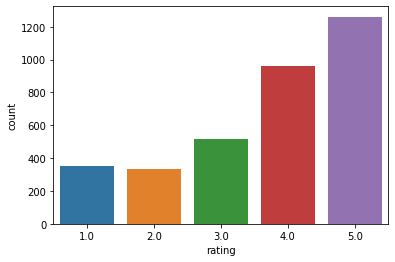

In [ ]:
import seaborn
seaborn.countplot(df['rating'])

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


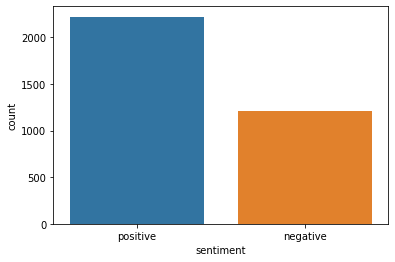

In [ ]:
seaborn.countplot(df['sentiment'])

In [ ]:
index_real = np.where(result['sentiment']=='positive')
index_fake = np.where(result['sentiment']=='negative')

In [ ]:
reviews = result.iloc[index_fake[0]]
review_real = result.iloc[index_real[0][:len(index_fake[0])]]
dfs = reviews.append(review_real)

In [ ]:
dfs['sentiment'] = np.where(dfs['sentiment'] == 'positive', 1,0)

In [ ]:
dfs.dtypes

number             int64
website           object
hotel             object
review            object
rating           float64
sentiment          int64
cleanreviews      object
Unnamed: 0         int64
summarization     object
dtype: object

In [ ]:
train_texts = dfs['cleanreviews']
y = dfs['sentiment']

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


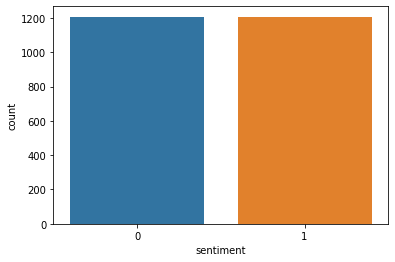

In [ ]:
seaborn.countplot(y)

In [ ]:
corpus = {}
for doc in train_texts:
    for w in doc.split():
        if w not in corpus:
            corpus[w]=len(corpus)
        
X = []
for doc in train_texts:
    count = {}
    vector = np.zeros(len(corpus))
    for w in doc.split():
        if w not in count:
            count[w]=1
        else:
            count[w]+=1
    for k, v in count.items():
        index = corpus[k]
        vector[index]=v
    X.append(vector)

In [ ]:
X3 = np.array(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.20, random_state = 0, stratify = y)

In [ ]:
clf = MultinomialNB(alpha = 1)
clf.fit(X_train, y_train)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [ ]:
print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))

Test set score: 0.88


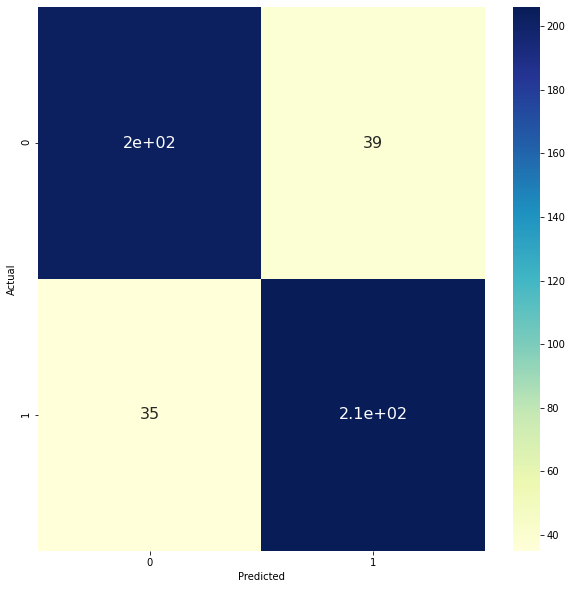

In [ ]:
y_pred_nv = clf.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred_nv)
df_cm = pd.DataFrame(conf_mat, columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,10))
seaborn.heatmap(df_cm,cmap= "YlGnBu", annot=True,annot_kws={"size": 16})
# # plt.savefig("bayes confusion")

In [ ]:
print(classification_report(y_test, y_pred_nv))

              precision    recall  f1-score   support

           0       0.85      0.84      0.85       242
           1       0.84      0.85      0.85       241

    accuracy                           0.85       483
   macro avg       0.85      0.85      0.85       483
weighted avg       0.85      0.85      0.85       483



In [ ]:
clf = SVC(C = 2)
clf.fit(X_train, y_train)

SVC(C=2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))

Test set score: 0.89


In [ ]:
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
print("Test set score: {:.2f}".format(clf.score(X_test, y_test)))

Test set score: 0.83


In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [ ]:
layers = keras.layers

model = Sequential()
model.add(layers.Dense(2,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model.fit(X_train,
                   y_train,
                   epochs=20,
                   batch_size=200,
                   validation_data=(X_test,y_test))

Epoch 1/20
10/10 [==============================] - 0s 18ms/step - loss: 0.6711 - accuracy: 0.5697 - val_loss: 0.6462 - val_accuracy: 0.6149
Epoch 2/20
10/10 [==============================] - 0s 8ms/step - loss: 0.6079 - accuracy: 0.7343 - val_loss: 0.5801 - val_accuracy: 0.8054
Epoch 3/20
10/10 [==============================] - 0s 8ms/step - loss: 0.5326 - accuracy: 0.8659 - val_loss: 0.5226 - val_accuracy: 0.8323
Epoch 4/20
10/10 [==============================] - 0s 8ms/step - loss: 0.4693 - accuracy: 0.8975 - val_loss: 0.4766 - val_accuracy: 0.8364
Epoch 5/20
10/10 [==============================] - 0s 8ms/step - loss: 0.4202 - accuracy: 0.9094 - val_loss: 0.4420 - val_accuracy: 0.8468
Epoch 6/20
10/10 [==============================] - 0s 8ms/step - loss: 0.3813 - accuracy: 0.9146 - val_loss: 0.4152 - val_accuracy: 0.8509
Epoch 7/20
10/10 [==============================] - 0s 8ms/step - loss: 0.3501 - accuracy: 0.9218 - val_loss: 0.3926 - val_accuracy: 0.8551
Epoch 8/20
10/10 [=